# Artificial Neural Networks Homework 3

Caden Matthews

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import yfinance as yf
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, Callback, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger

torch.set_float32_matmul_precision('high')
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Attempt to forecast the price of MSFT by analyzing the prices of multiple stocks, including MSFT, over several consecutive days leading up to the target day.

In [2]:
class StockDataset(Dataset):
    def __init__(self, X, Y, days):
        self.X = X.astype(np.float32)
        self.Y = Y.reshape(-1).astype(np.float32)
        self.days = days  # days ahead for prediction

    def __len__(self):
        return len(self.Y) - self.days

    def __getitem__(self, index):
        x = self.X[:, index : index + self.days]
        y = self.Y[index + self.days]
        return x, y

In [3]:
def get_prices(tickers, start="2020-01-01"):
    df = pd.DataFrame({t: yf.Ticker(t).history(start=start)["Close"] for t in tickers})
    return df

def prepare_dataloaders(feature_stocks, predict_stock, days=30):
    Xdf = get_prices(feature_stocks).ffill()
    Ydf = get_prices([predict_stock]).ffill()
    dates = Ydf.index

    X = Xdf.to_numpy().T    # (num_feature_stocks, T)
    Y = Ydf.to_numpy()      # (T,1)
    dataset = StockDataset(X, Y, days)

    # sequential 70/15/15 split
    n = len(dataset)
    n_train = int(n * 0.7)
    n_val   = int(n * 0.15)
    n_test  = n - n_train - n_val

    train_ds = Subset(dataset, range(0, n_train))
    val_ds   = Subset(dataset, range(n_train, n_train + n_val))
    test_ds  = Subset(dataset, range(n_train + n_val, n))

    train_dl = DataLoader(train_ds, batch_size=len(train_ds), shuffle=False)
    val_dl   = DataLoader(val_ds,   batch_size=len(val_ds),   shuffle=False)
    test_dl  = DataLoader(test_ds,  batch_size=len(test_ds),  shuffle=False)

    return train_dl, val_dl, test_dl, dates, n_train, n_val

feature_stocks = ["tsla","meta","sony","amzn","nflx","gbtc","gdx","intc","dal","c",
                    "goog","aapl","msft","ibm","hp","orcl","sap","crm","hubs","twlo"]
predict_stock = "msft"
days = 30  # extended lookback window

train_dl, val_dl, test_dl, dates, n_train, n_val = prepare_dataloaders(feature_stocks,
                                                                       predict_stock, days)

## RNN Model with LSTM Layer

In [4]:
class RNNForecast(pl.LightningModule):
    def __init__(self, num_feature_stocks, days, hidden_dim=128, num_layers=2,
                 bidirectional=False, dropout=0.2, lr=5e-4, weight_decay=1e-5, use_huber=False):
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(input_size=num_feature_stocks, hidden_size=hidden_dim, num_layers=num_layers,
                            dropout=dropout if num_layers > 1 else 0.0, bidirectional=bidirectional,
                            batch_first=True)
        
        # Initialize forget-gate biases to 1
        for names in self.lstm._all_weights:
            for name in filter(lambda n: "bias" in n, names):
                bias = getattr(self.lstm, name)
                n_bias = bias.size(0)
                start, end = n_bias // 4, n_bias // 2
                nn.init.constant_(bias.data[start:end], 1.0)

        self.layernorm = nn.LayerNorm(hidden_dim * (2 if bidirectional else 1))
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), 1)
        self.lr = lr
        self.weight_decay = weight_decay
        self.use_huber = use_huber

    # Permute input to (batch, seq_len, feats) for LSTM
    def forward(self, x):
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x) 
        last = out[:, -1, :]  
        norm = self.layernorm(last)
        return self.fc(norm).squeeze()

    # Step function for training/validation/testing
    def _step(self, batch, stage):
        x, y = batch
        y_hat = self(x)
        if self.use_huber:
            loss = F.smooth_l1_loss(y_hat, y)
        else:
            loss = F.mse_loss(y_hat, y)
        self.log(f"{stage}_mse", loss, prog_bar=True)
        return loss

    # Training step
    def training_step(self, batch, idx):
        return self._step(batch, "train")

    # Validation step
    def validation_step(self, batch, idx):
        return self._step(batch, "val")

    # Test step
    def test_step(self, batch, idx):
        return self._step(batch, "test")

    # Optimizer and scheduler configuration
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                      weight_decay=self.weight_decay)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                                               factor=0.5, patience=5)
        
        return {'optimizer': optimizer, 'lr_scheduler': 
                {'scheduler': scheduler,'monitor': 'val_mse'}}

## Attention Network with Self Attention Layer

In [5]:
class SelfAttentionForecast(pl.LightningModule):
    def __init__(self, num_feature_stocks, days, d_model=128, n_heads=8, num_layers=1,
                 dropout=0.2, lr=5e-4, weight_decay=1e-5, use_huber=False):
        super().__init__()
        self.save_hyperparameters()
        self.input_fc = nn.Linear(num_feature_stocks, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, days, d_model))

        # Initialize positional encoding
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads,
                                                   dim_feedforward=d_model * 4, dropout=dropout,batch_first=True)
        
        # Create transformer encoder with specified number of layers
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.layernorm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 1)
        self.lr = lr
        self.weight_decay = weight_decay
        self.use_huber = use_huber

    # Permute input to (batch, seq_len, feats) for transformer
    def forward(self, x):
        x = x.permute(0, 2, 1)           
        x = self.input_fc(x)          
        x = x + self.positional_encoding[:, :x.size(1), :]
        enc = self.transformer(x)      
        # Final layernorm + residual
        enc = self.layernorm(enc + x)
        # Pool and project
        enc = enc.permute(0, 2, 1)      
        pooled = self.pool(enc).squeeze(-1)
        return self.fc(pooled).squeeze()

    # Step function for training/validation/testing
    def _step(self, batch, stage):
        x, y = batch
        y_hat = self(x)
        if self.use_huber:
            loss = F.smooth_l1_loss(y_hat, y)
        else:
            loss = F.mse_loss(y_hat, y)
        self.log(f"{stage}_mse", loss, prog_bar=True)
        return loss

    # Training step
    def training_step(self, batch, idx):
        return self._step(batch, "train")

    # Validation step
    def validation_step(self, batch, idx):
        return self._step(batch, "val")

    # Test step
    def test_step(self, batch, idx):
        return self._step(batch, "test")

    # Optimizer and scheduler configuration
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                      weight_decay=self.weight_decay)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                                               factor=0.5, patience=5)
        
        return {'optimizer': optimizer, 'lr_scheduler': 
                {'scheduler': scheduler, 'monitor': 'val_mse'}}

# Knowledge Distillation

In [6]:
class SmallRNNForecast(pl.LightningModule):
    def __init__(self, num_feature_stocks, days,
                 hidden_dim=64,
                 num_layers=1,
                 bidirectional=False,
                 dropout=0.2,
                 lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(input_size=num_feature_stocks, hidden_size=hidden_dim,
                            num_layers=num_layers, dropout=dropout, bidirectional=bidirectional,
                            batch_first=True)
        
        # Initialize forget-gate biases
        for names in self.lstm._all_weights:
            for name in filter(lambda n: "bias" in n, names):
                bias = getattr(self.lstm, name)
                n_bias = bias.size(0)
                start, end = n_bias // 4, n_bias // 2
                nn.init.constant_(bias.data[start:end], 1.0)

        self.layernorm = nn.LayerNorm(hidden_dim * (2 if bidirectional else 1))
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), 1)
        self.lr = lr

    # Permute input to (batch, seq_len, feats) for LSTM
    def forward(self, x):
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        norm = self.layernorm(last)
        return self.fc(norm).squeeze()

    # Training step with knowledge distillation
    def training_step(self, batch, idx):
        x, y = batch
        with torch.no_grad():
            teacher_preds = self.teacher(x)
        student_preds = self(x)
        loss_kd = F.mse_loss(student_preds, teacher_preds)
        loss_true = F.mse_loss(student_preds, y)
        loss = 0.5 * loss_kd + 0.5 * loss_true
        self.log("train_mse", loss, prog_bar=True)
        return loss

    # Validation step
    def validation_step(self, batch, idx):
        x, y = batch
        preds = self(x)
        loss = F.mse_loss(preds, y)
        self.log("val_mse", loss, prog_bar=True)
        return loss

    # Test step
    def test_step(self, batch, idx):
        x, y = batch
        preds = self(x)
        loss = F.mse_loss(preds, y)
        self.log("test_mse", loss, prog_bar=True)
        return loss

    # Optimizer configuration
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)

## Mamba Network

In [7]:
class MambaLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.proj = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.out  = nn.Linear(hidden_dim, input_dim)
        self.act  = nn.ReLU()

    def forward(self, x):
        u = self.act(self.proj(x))
        g = torch.sigmoid(self.gate(x))
        m = u * g
        return self.out(m) + x

class MambaForecast(pl.LightningModule):
    def __init__(self, num_feature_stocks, days, hidden_dim=128, num_layers=2, 
                 dropout=0.2, lr=5e-4, weight_decay=1e-5, use_huber=False):
        super().__init__()
        self.save_hyperparameters()
        layers = []
        for _ in range(num_layers):
            layers.append(MambaLayer(num_feature_stocks, hidden_dim))
            layers.append(nn.Dropout(dropout))
        self.mamba_layers = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc   = nn.Linear(num_feature_stocks, 1)
        self.lr  = lr
        self.weight_decay = weight_decay
        self.use_huber = use_huber

    # Permute input to (batch, seq_len, feats) for Mamba
    def forward(self, x):
        x = x.permute(0, 2, 1)         
        x = self.mamba_layers(x)       
        x = x.permute(0, 2, 1)      
        pooled = self.pool(x).squeeze(-1) 
        return self.fc(pooled).squeeze()

    # Step function for training/validation/testing
    def _step(self, batch, stage):
        x, y = batch
        y_hat = self(x)
        loss = F.smooth_l1_loss(y_hat, y) if self.use_huber else F.mse_loss(y_hat, y)
        self.log(f"{stage}_mse", loss, prog_bar=True)
        return loss

    # Training step
    def training_step(self, batch, idx): 
        return self._step(batch, "train")
    
    # Validation step
    def validation_step(self, batch, idx): 
        return self._step(batch, "val")
    
    # Test step
    def test_step(self, batch, idx):       
        return self._step(batch, "test")

    # Optimizer and scheduler configuration
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=5)
        return {'optimizer': opt, 'lr_scheduler': {'scheduler': sched, 'monitor': 'val_mse'}}

## Callback and Plot Utilities

In [8]:
# Callback to track training/validation loss
class LossHistory(Callback):
    def __init__(self):
        super().__init__()
        self.train_mse, self.val_mse = [], []
    def on_train_epoch_end(self, trainer, pl_module):
        self.train_mse.append(trainer.callback_metrics["train_mse"].item())
    def on_validation_epoch_end(self, trainer, pl_module):
        self.val_mse.append(trainer.callback_metrics["val_mse"].item())

def plot_loss_curve(hist: LossHistory, title: str):
    plt.figure(figsize=(6,4))
    plt.plot(hist.train_mse, label="Train MSE")
    plt.plot(hist.val_mse,   label="Val   MSE")
    plt.title(f"{title} Loss Curve")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()

def plot_forecast(model, dl, dates, n_train, n_val, days, title: str):
    model.eval()
    x, y_true = next(iter(dl))
    with torch.no_grad():
        y_pred = model(x).cpu().numpy()
    start = n_train + n_val + days
    dts = dates[start:start + len(y_pred)]
    plt.figure(figsize=(8,4))
    plt.plot(dts, y_true.numpy(), label="Actual")
    plt.plot(dts, y_pred, label="Predicted", alpha=0.8)
    plt.title(f"{title} Forecast"); plt.xlabel("Date"); plt.ylabel("Price")
    plt.legend(); plt.tight_layout(); plt.show()

In [9]:
def train_and_plot(model_cls, name, **kwargs):
    model  = model_cls(num_feature_stocks=len(feature_stocks), days=days, **kwargs)
    logger = CSVLogger("logs", name=name)
    es     = EarlyStopping(monitor="val_mse", patience=5, mode="min")
    hist   = LossHistory()
    lrmon  = LearningRateMonitor(logging_interval="epoch")
    trainer = Trainer(max_epochs=50, gradient_clip_val=5.0,
                      callbacks=[es, hist, lrmon],
                      logger=logger, enable_checkpointing=False,
                      accelerator="auto", devices=1,
                      enable_progress_bar=False)
    trainer.fit(model, train_dl, val_dl)
    res = trainer.test(model, test_dl, verbose=False)[0]["test_mse"]
    plot_loss_curve(hist, name); plot_forecast(model, test_dl, dates, n_train, n_val, days, name)
    print(f"{name} Test MSE = {res:.4f}\n")
    return model, res

def train_and_plot_distill(teacher, student_cls, name, **kwargs):
    student = student_cls(num_feature_stocks=len(feature_stocks), days=days, **kwargs)
    student.teacher = teacher.eval()
    for p in teacher.parameters():
        p.requires_grad_(False)

    logger = CSVLogger("logs", name=name)
    es     = EarlyStopping(monitor="val_mse", patience=5, mode="min")
    hist   = LossHistory()
    lrmon  = LearningRateMonitor(logging_interval="epoch")

    trainer = Trainer(max_epochs=3000, gradient_clip_val=5.0, callbacks=[es, hist, lrmon],
                      logger=logger, enable_checkpointing=False, enable_progress_bar=False,
                      accelerator="auto", devices=1)
    trainer.fit(student, train_dl, val_dl)
    test_res = trainer.test(student, test_dl, verbose=False)[0]["test_mse"]

    plot_loss_curve(hist, name)
    plot_forecast(student, test_dl, dates, n_train, n_val, days, name)
    print(f"{name} Test MSE = {test_res:.4f}\n")
    return test_res

## Train and Compare Models

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | lstm      | LSTM      | 208 K  | train
1 | layernorm | LayerNorm | 256    | train
2 | fc        | Linear    | 129    | train
------------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.837     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck.

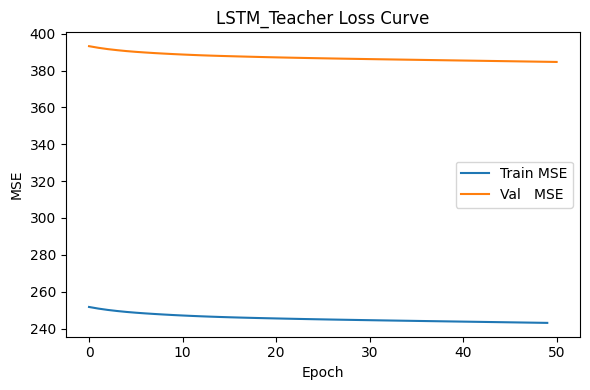

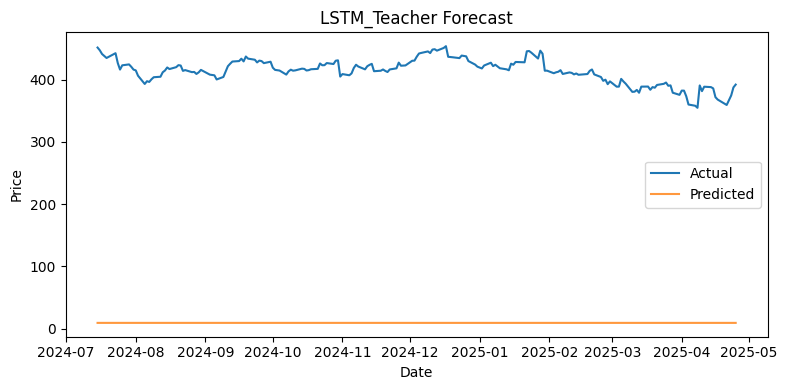

LSTM_Teacher Test MSE = 403.8912



In [10]:
# Train RNN teacher
teacher_model, teacher_mse = train_and_plot(RNNForecast, "LSTM_Teacher", hidden_dim=128,
                                            num_layers=2, bidirectional=False, dropout=0.2,
                                            lr=5e-4, weight_decay=1e-5, use_huber=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | input_fc     | Linear             | 2.7 K  | train
1 | transformer  | TransformerEncoder | 396 K  | train
2 | layernorm    | LayerNorm          | 256    | train
3 | dropout      | Dropout            | 0      | train
4 | pool         | AdaptiveAvgPool1d  | 0      | train
5 | fc           | Linear             | 129    | train
  | other params | n/a                | 3.8 K  | n/a  
------------------------------------------------------------
403 K     Trainable params
0         Non-trainable params
403 K     Total params
1.614     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: 

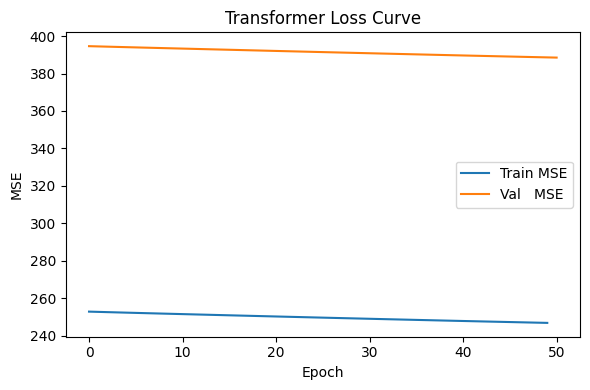

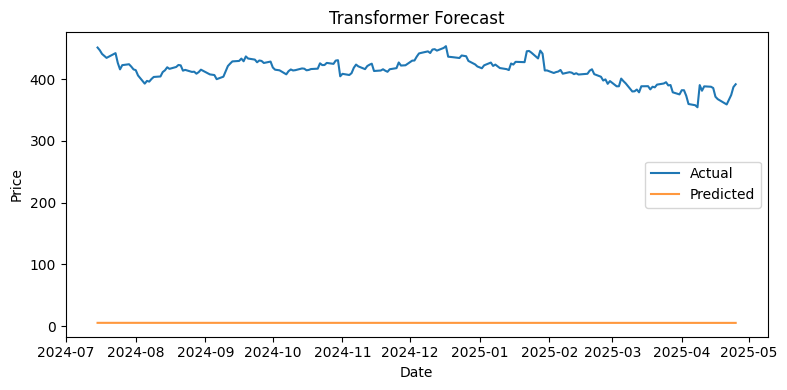

Transformer Test MSE = 407.7943



In [11]:
# Train Transformer model
attn_model, attn_mse = train_and_plot(
        SelfAttentionForecast, "Transformer", d_model=128, n_heads=8, num_layers=2,
        dropout=0.2, lr=5e-4, weight_decay=1e-5, use_huber=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | lstm      | LSTM        | 22.0 K | train
1 | layernorm | LayerNorm   | 128    | train
2 | fc        | Linear      | 65     | train
3 | teacher   | RNNForecast | 209 K  | eval 
--------------------------------------------------
22.2 K    Trainable params
209 K     Non-trainable params
231 K     Total params
0.926     Total estimated model params size (MB)
3         Modules in train mode
4         Modules in eval mode
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


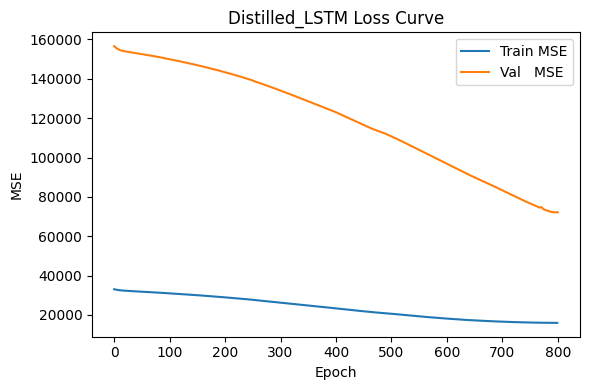

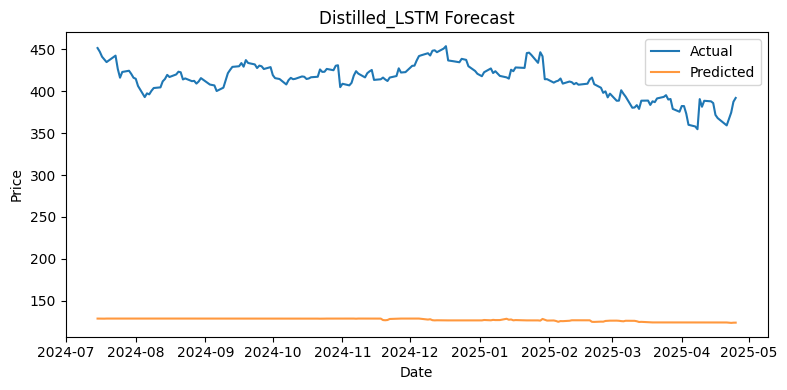

Distilled_LSTM Test MSE = 82266.4453



In [12]:
# Distill into small student model
distill_mse = train_and_plot_distill(teacher_model, SmallRNNForecast, "Distilled_LSTM",
                                     hidden_dim=64, num_layers=1, bidirectional=False,
                                     dropout=0.0, lr=1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | mamba_layers | Sequential        | 15.9 K | train
1 | pool         | AdaptiveAvgPool1d | 0      | train
2 | fc           | Linear            | 21     | train
-----------------------------------------------------------
15.9 K    Trainable params
0         Non-trainable params
15.9 K    Total params
0.064     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


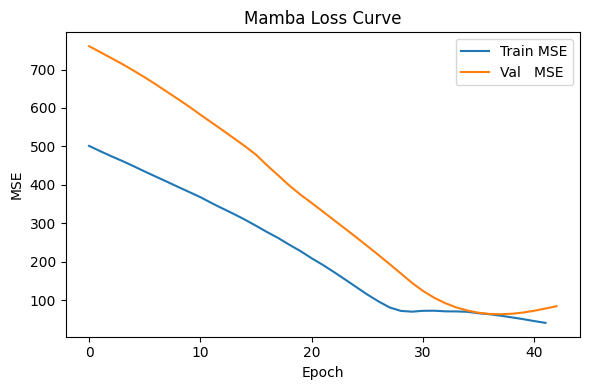

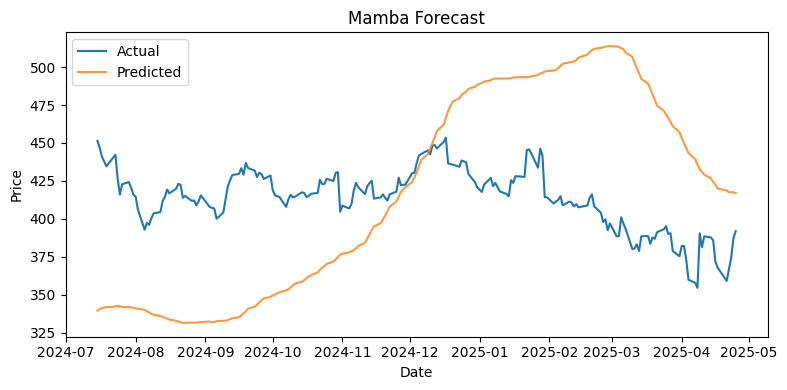

Mamba Test MSE = 65.9579



In [13]:
# Train Mamba model
mamba_model, mamba_mse = train_and_plot(MambaForecast, "Mamba", hidden_dim=128, num_layers=2,
                                        dropout=0.2, lr=5e-4, weight_decay=1e-5, use_huber=True)

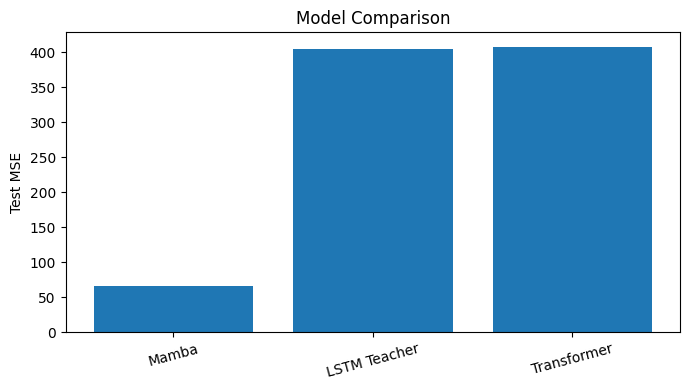

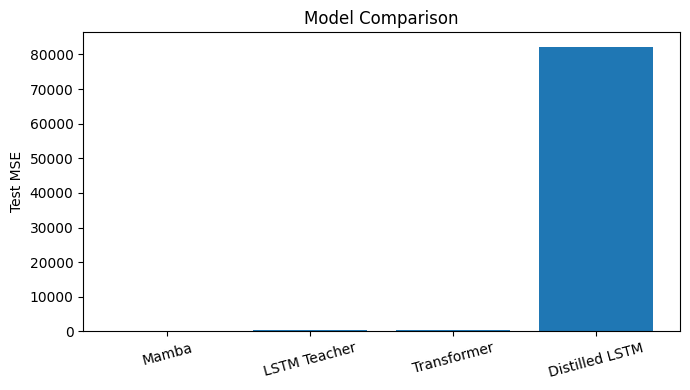

In [14]:
# Final comparison bar chart
results = {"Mamba":          mamba_mse,
           "LSTM Teacher":   teacher_mse,
           "Transformer":    attn_mse}

plt.figure(figsize=(7, 4))
plt.bar(results.keys(), results.values())
plt.ylabel("Test MSE")
plt.title("Model Comparison")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

results = {"Mamba":          mamba_mse,
           "LSTM Teacher":   teacher_mse,
           "Transformer":    attn_mse,
           "Distilled LSTM": distill_mse}

plt.figure(figsize=(7, 4))
plt.bar(results.keys(), results.values())
plt.ylabel("Test MSE")
plt.title("Model Comparison")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [15]:
# Display model weights
def print_model_weights(model, name):
    print(f"\n=== Weights for {name} ===")
    for param_name, param in model.named_parameters():
        print(f"{param_name}: {param.detach().cpu().numpy()}")

print_model_weights(teacher_model, "LSTM_Teacher")


=== Weights for LSTM_Teacher ===
lstm.weight_ih_l0: [[ 0.0675763   0.07336303 -0.02070696 ...  0.01306459 -0.04126321
   0.02253004]
 [-0.03796243 -0.01069153 -0.0346255  ...  0.07184282  0.01125004
  -0.02848037]
 [ 0.0237485  -0.0239691   0.03719891 ... -0.00153759  0.06917345
  -0.06280112]
 ...
 [-0.02795619  0.08841219  0.00190983 ...  0.03305968 -0.04710998
   0.06948047]
 [ 0.07783675 -0.0281531   0.06102054 ... -0.04381848 -0.02785249
  -0.03061885]
 [-0.01821324  0.01875547  0.00270698 ...  0.07985359 -0.0479215
   0.00171786]]
lstm.weight_hh_l0: [[-0.01447087 -0.00282541  0.03682243 ... -0.07014887 -0.0068961
   0.06265754]
 [-0.02807507  0.08341964  0.08573447 ...  0.0263582  -0.04274227
   0.00987159]
 [ 0.08190855 -0.02607357  0.02258193 ...  0.04879283 -0.00745001
  -0.08571157]
 ...
 [-0.00684526  0.09341481 -0.08321007 ...  0.08507653  0.08338725
  -0.0792613 ]
 [ 0.06354559 -0.0481735  -0.02442829 ...  0.0570359  -0.06828351
   0.07167502]
 [ 0.03224125 -0.06431174 -0

In [16]:
print_model_weights(attn_model,    "Transformer")


=== Weights for Transformer ===
positional_encoding: [[[ 0.02407381 -0.02332542 -0.02182794 ... -0.02579965 -0.01777879
    0.02176693]
  [ 0.02430199 -0.02340878 -0.02179994 ... -0.02578206 -0.01785366
    0.0214876 ]
  [ 0.02450266 -0.02332817 -0.02183795 ... -0.02577289 -0.01775203
    0.02163781]
  ...
  [ 0.02506509 -0.0232785  -0.02195827 ... -0.02580133 -0.01748174
    0.02204736]
  [ 0.02458862 -0.0234133  -0.02187973 ... -0.02578005 -0.0175619
    0.02173772]
  [ 0.02453844 -0.02337133 -0.02188373 ... -0.02578955 -0.01761522
    0.02176598]]]
input_fc.weight: [[-0.07205569  0.09738648  0.03279456 ... -0.08146842  0.04566376
   0.03028226]
 [-0.1604553   0.10172034 -0.13414967 ...  0.08180162 -0.00494257
  -0.13833411]
 [-0.20582686 -0.03197626  0.1235847  ...  0.19745143  0.05768237
   0.07699691]
 ...
 [ 0.16995725  0.1042173  -0.0055108  ...  0.19496438  0.08860437
  -0.19778338]
 [-0.09466139  0.03765347  0.18390082 ... -0.0026212  -0.0459824
  -0.11664312]
 [-0.10520945 -

In [17]:
print_model_weights(mamba_model,   "Mamba")


=== Weights for Mamba ===
mamba_layers.0.proj.weight: [[ 0.10348541  0.13250309  0.16482282 ... -0.09652935  0.03900862
  -0.2101219 ]
 [-0.06835796  0.18811509 -0.16202602 ... -0.19094256  0.06810249
  -0.16004004]
 [-0.06677917 -0.192844    0.0507853  ...  0.19468805  0.09377775
  -0.11152015]
 ...
 [-0.19304626  0.16407399  0.16778034 ... -0.02761557 -0.09639588
  -0.15603997]
 [ 0.04065057  0.17844553 -0.14019884 ...  0.20134939  0.08952628
  -0.17821136]
 [ 0.1878616  -0.10918982 -0.00227428 ...  0.04873786 -0.06035762
  -0.09371776]]
mamba_layers.0.proj.bias: [-1.09219447e-01  1.88772127e-01 -2.04155207e-01  6.85239285e-02
  1.74967945e-01  1.81582570e-02  1.16019003e-01  1.81041986e-01
 -1.61420703e-01 -5.21043390e-02  9.14680138e-02 -1.59352094e-01
 -7.24909157e-02 -1.15604654e-01  1.19226780e-02  1.98380917e-01
 -1.31922230e-01  4.43484681e-03  1.79006010e-01 -2.04478815e-01
  7.94365108e-02  4.45776656e-02  2.09873870e-01 -7.54465014e-02
 -1.11186124e-01 -1.58430994e-01  1.2